In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [88]:
df_calls = pd.read_csv('/kaggle/input/ua-hackathon/callsf0d4f5a.csv')
df_reasons = pd.read_csv('/kaggle/input/ua-hackathon/reason18315ff.csv')

df_calls = df_calls.dropna(subset=['call_transcript'])
if df_calls['call_transcript'].empty:
        raise ValueError("No valid transcripts found after removing NaN values.")

In [89]:
def separate_dialogues(transcript):
    lines = transcript.split('\n')
    customer_lines = []
    agent_lines = []
    for line in lines:
        if line.lower().startswith('customer:'):
            customer_lines.append(line.split(':', 1)[1].strip())
        elif line.lower().startswith('agent:'):
            agent_lines.append(line.split(':', 1)[1].strip())
    return ' '.join(customer_lines), ' '.join(agent_lines)

In [93]:
import re
import spacy
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from collections import Counter

# Load spacy model for more advanced preprocessing
nlp = spacy.load('en_core_web_sm')

In [94]:
def preprocess_text(text):
    additional_stopwords = ['ugh', 'really', 'need', 'help', 'please', 'thank', 'you', 'thanks', 'agent']
    stop_words = set(stopwords.words('english')).union(set(additional_stopwords))
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return tokens

In [ ]:
df_calls['customer_text'], df_calls['agent_text'] = zip(*df_calls['call_transcript'].apply(separate_dialogues))
processed_transcripts = df_calls['customer_text'].apply(preprocess_text)
df_calls['processed_customer'] = df_calls['customer_text'].apply(preprocess_text)
df_calls['processed_agent'] = df_calls['agent_text'].apply(preprocess_text)

In [ ]:
dictionary = corpora.Dictionary(processed_transcripts)
dictionary.filter_extremes(no_below=1, no_above=0.5)  # Adjust thresholds as needed
corpus = [dictionary.doc2bow(text) for text in processed_transcripts]


In [8]:
df_reasons.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [ ]:
final_df = pd.merge(df_calls, df_reasons, how='right', on='call_id')

In [11]:
len(final_df)

66653

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(final_df['processed_customer'])
X_text_array = tfidf_matrix.toarray()
# print(tfidf_matrix)

In [13]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)

final_df['cluster'] = kmeans.labels_
final_df.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_text,agent_text,processed_customer,processed_agent,primary_call_reason,cluster
0,4667960400,2033123310,963118,7/31/2024 23:56,08-01-2024 00:03,08-01-2024 00:34,\n\nAgent: Thank you for calling United Airlin...,"Hi, yeah I'm calling because my flight from Ch...",Thank you for calling United Airlines customer...,hi yeah calling flight chicago new york delaye...,thank calling united airlines customer service...,Voluntary Cancel,7
1,1122072124,8186702651,519057,08-01-2024 00:03,08-01-2024 00:06,08-01-2024 00:18,\n\nAgent: Thank you for calling United Airlin...,"Hi Sam, yeah I'm calling because I need to cha...","Thank you for calling United Airlines, my name...",hi sam yeah calling need change dates upcoming...,thank calling united airlines name sam help to...,Booking,9
2,6834291559,2416856629,158319,7/31/2024 23:59,08-01-2024 00:07,08-01-2024 00:26,\n\nAgent: Thank you for calling United Airlin...,"Hi Steve, uh, I'm calling because I need to ma...",Thank you for calling United Airlines customer...,hi steve uh calling need make change upcoming ...,thank calling united airlines customer service...,IRROPS,2
3,2266439882,1154544516,488324,08-01-2024 00:05,08-01-2024 00:10,08-01-2024 00:17,\n\nAgent: Thank you for calling United Airlin...,"Hi, yeah I'm calling because I'm having some i...",Thank you for calling United Airlines customer...,hi yeah calling issues flight booked ugh frust...,thank calling united airlines customer service...,Upgrade,0
4,1211603231,5214456437,721730,08-01-2024 00:04,08-01-2024 00:14,08-01-2024 00:23,\n\nAgent: Thank you for calling United Airlin...,"Hi Sarah, thanks for taking my call. I'm calli...",Thank you for calling United Airlines customer...,hi sarah thanks taking call calling flight com...,thank calling united airlines customer service...,Seating,2


In [14]:
feature_names = vectorizer.get_feature_names_out()
top_terms = {}
for i in range(10):
    center = kmeans.cluster_centers_[i]
    top_indices = center.argsort()[-10:][::-1]
    top_terms[i] = [feature_names[idx] for idx in top_indices]

In [15]:
count_vect = CountVectorizer(
    max_features=2000,
    ngram_range=(1,2),
    stop_words='english',
    min_df=5,
    max_df=0.8
)
X_count = count_vect.fit_transform(final_df['processed_customer'])

In [16]:
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic_num, topic_words in topics:
    print(f"Topic {topic_num}: {topic_words}")

In [17]:
#topic_terms = {}
no_top_words = 10
feature_names = count_vect.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    
# return transcripts, top_terms, topic_terms

Topic 1:
really ugh meeting guess booked earlier time work need way


Topic 2:
change need earlier help chicago umm booked ahead day appreciate


Topic 3:
time check wanted chicago taking umm appreciate good know taking time


Topic 4:
change really need appreciate fee really appreciate thank way day help


Topic 5:
guess hours better really delayed need guys united ugh want




In [53]:
labels = {}
num_labels = 2

for idx, terms in enumerate(top_terms):
    label = ' & '.join(terms[:num_labels]).title()
    labels[idx + 1] = label

In [18]:
topic_distributions = lda.transform(X_count)
final_df['dominant_topic'] = topic_distributions.argmax(axis=1) + 1

In [55]:
data = [np.nan, 'Seating', 'Voluntary Cancel', 'Voluntary Change', 'Post-Flight',
        'Communications', 'Baggage', 'Mileage Plus', 'IRROPS', 'IRROPS  ',
        'Digital   Support', 'Checkout', 'Check-In', 'Upgrade', 'Voluntary   Change',
        'Booking', 'Other Topics', 'ETC', 'Products & Services', 'Products and Services',
        'Digital Support', 'Post-Flight  ', 'Traveler   Updates', 'Voluntary  Change',
        'Traveler Updates', 'Voluntary  Cancel', 'Disability', 'Upgrade  ',
        'Digital  Support', 'Unaccompanied Minor', 'Mileage Plus  ', 'Traveler  Updates',
        'Check In', 'Schedule Change', 'Products and Services  ', 'Post Flight',
        'Mileage   Plus', 'Voluntary Change  ', 'Seating  ', 'Mileage  Plus',
        'Digital Support  ', 'Baggage  ', 'Other  Topics', 'Booking  ', ' Baggage',
        'Communications  ', 'Check-In  ', 'Traveler Updates  ', 'Unaccompanied Minor  ',
        'Checkout  ', 'ETC  ', 'Schedule Change  ', 'Other Topics  ', 'Voluntary Cancel  ',
        'Disability  ']

final_df['primary_call_reason'] = final_df['primary_call_reason'].str.strip()  # Remove leading/trailing spaces
final_df['primary_call_reason'] = final_df['primary_call_reason'].str.title()  # Convert to title case

final_df['primary_call_reason'] = final_df['primary_call_reason'].replace({
    'Voluntary Cancel': 'Voluntary Cancel',
    'Voluntary  Cancel': 'Voluntary Cancel',
    'Voluntary Change': 'Voluntary Change',
    'Voluntary   Change': 'Voluntary Change',
    'Voluntary  Change': 'Voluntary Change',
    'Products & Services': 'Products and Services',
    'Products and Services  ': 'Products and Services',
    'Products and Services  ': 'Products and Services',
    'Digital Support': 'Digital Support',
    'Digital   Support': 'Digital Support',
    'Digital  Support': 'Digital Support',
    'Baggage': 'Baggage',
    'Baggage  ': 'Baggage',
    'Mileage Plus': 'Mileage Plus',
    'Mileage   Plus': 'Mileage Plus',
    'Mileage  Plus': 'Mileage Plus',
    'Check-In': 'Check-In',
    'Check-In  ': 'Check-In',
    'Check In': 'Check-In',
    'Check In  ': 'Check-In',
    'Schedule Change': 'Schedule Change',
    'Schedule Change  ': 'Schedule Change',
    'Unaccompanied Minor': 'Unaccompanied Minor',
    'Unaccompanied Minor  ': 'Unaccompanied Minor',
    'Other Topics': 'Other Topics',
    'Other Topics  ': 'Other Topics',
    'Other  Topics': 'Other Topics',
    'Traveler Updates': 'Traveler Updates',
    'Traveler  Updates  ': 'Traveler Updates',
    'Traveler   Updates': 'Traveler Updates',
    'Traveler  Updates': 'Traveler Updates',
    'Post-Flight': 'Post-Flight',
    'Post-Flight  ': 'Post-Flight',
    'Post Flight': 'Post-Flight',
    'Post Flight  ': 'Post-Flight',
})


In [56]:
reason_counts = final_df['primary_call_reason'].value_counts()

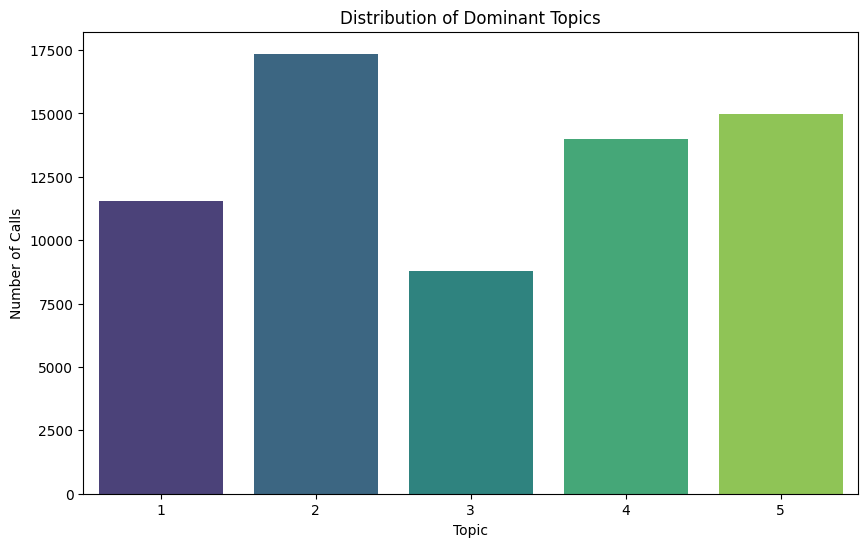

In [57]:
plt.figure(figsize=(10,6))
sns.countplot(x='dominant_topic', data=final_df, palette='viridis')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Calls')
plt.show()

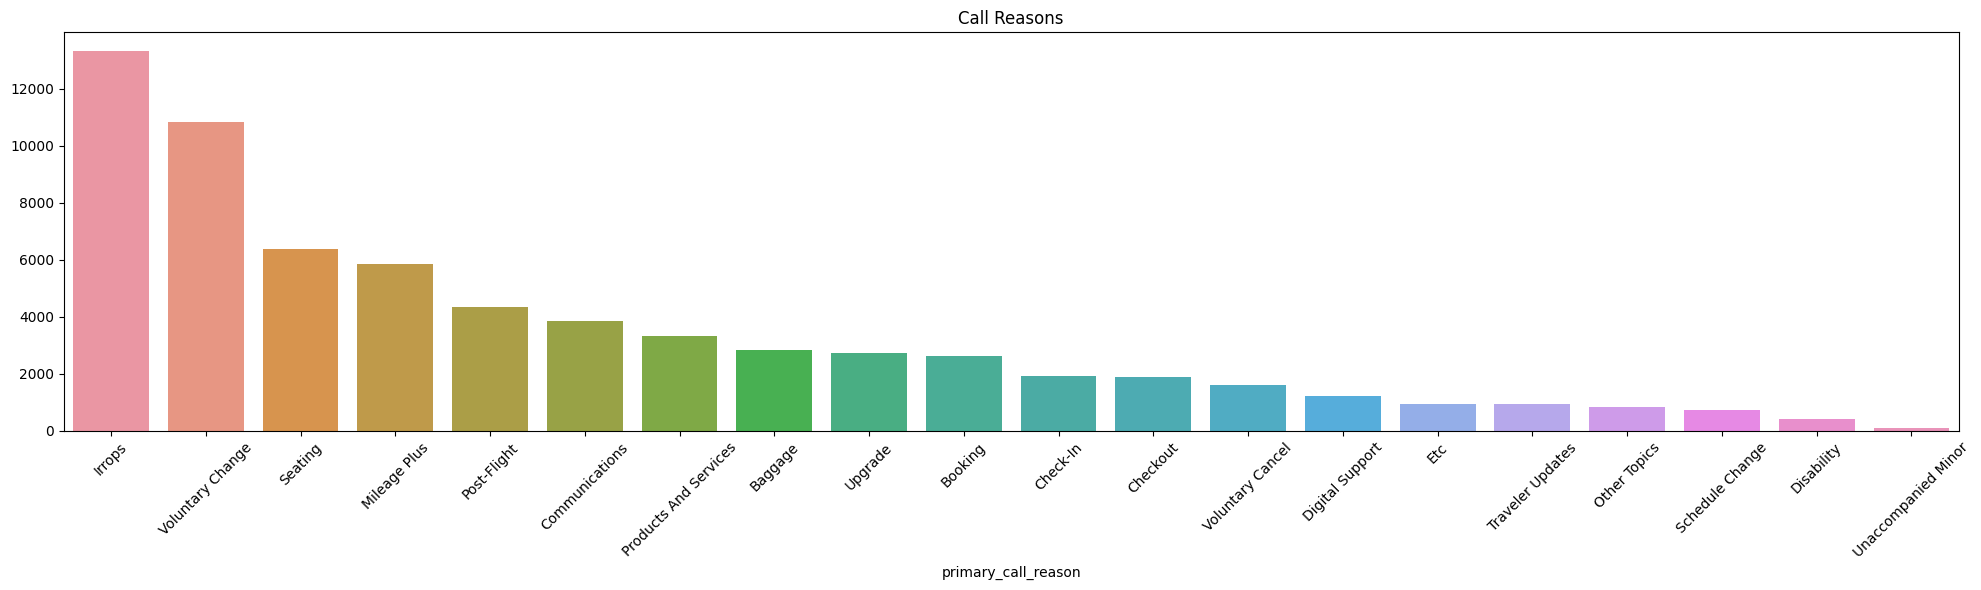

In [81]:
plt.figure(figsize=(20, 6))
sns.barplot(x=reason_counts.index[:], y=reason_counts.values[:])
plt.title('Call Reasons')
plt.xticks(rotation=45)
plt.tight_layout()

In [59]:
print(top_terms)

[['really', 'ugh', 'meeting', 'guess', 'booked', 'earlier', 'time', 'work', 'need', 'way'], ['change', 'need', 'earlier', 'help', 'chicago', 'umm', 'booked', 'ahead', 'day', 'appreciate'], ['time', 'check', 'wanted', 'chicago', 'taking', 'umm', 'appreciate', 'good', 'know', 'taking time'], ['change', 'really', 'need', 'appreciate', 'fee', 'really appreciate', 'thank', 'way', 'day', 'help'], ['guess', 'hours', 'better', 'really', 'delayed', 'need', 'guys', 'united', 'ugh', 'want']]


Text(0.5, 1.0, 'Word Cloud of Customer Transcripts')

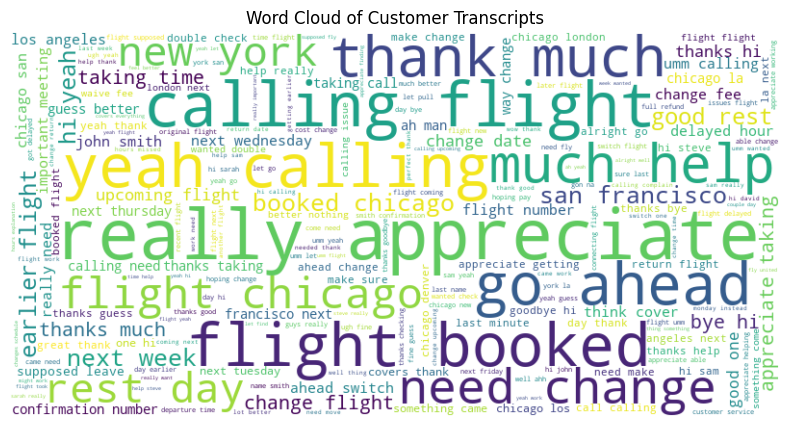

In [63]:
all_customer_text = ' '.join(final_df['processed_customer'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_customer_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Transcripts')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Transcript Length (characters)')

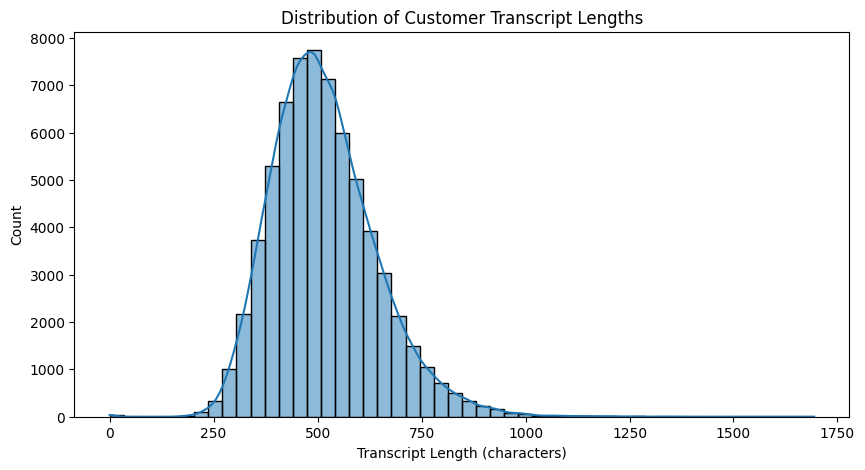

In [65]:
final_df['customer_length'] = final_df['processed_customer'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(final_df['customer_length'], bins=50, kde=True)
plt.title('Distribution of Customer Transcript Lengths')
plt.xlabel('Transcript Length (characters)')

NameError: name 'topic_terms' is not defined

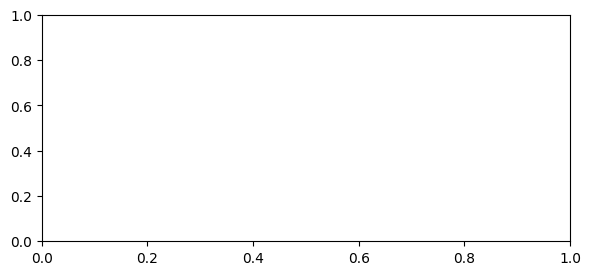

In [66]:
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.barplot(x=range(10), y=topic_terms[i])
    plt.title(f'Topic {i}')
    plt.xticks([])
plt.tight_layout()


In [30]:
num_top_terms = 10

top_terms = []
top_weights = []

for topic_idx, topic in enumerate(lda.components_):
    # Get indices of the top terms
    top_indices = topic.argsort()[:-num_top_terms - 1:-1]
    # Get the top terms based on the indices
    terms = [count_vect.get_feature_names_out()[i] for i in top_indices]
    # Get the corresponding weights
    weights = topic[top_indices]
    
    top_terms.append(terms)
    top_weights.append(weights)

In [67]:
topic_reason_crosstab = pd.crosstab(final_df['dominant_topic'], final_df['primary_call_reason'])
print(topic_reason_crosstab)

primary_call_reason  Baggage  Booking  Check-In  Checkout  Communications  \
dominant_topic                                                              
1                        532      477       300       334             630   
2                        791      760       517       508            1029   
3                        342      312       257       223             493   
4                        604      554       377       389             837   
5                        563      534       453       434             851   

primary_call_reason  Digital Support  Disability  Etc  Irrops  Mileage Plus  \
dominant_topic                                                                
1                                195          85  176    2159          1061   
2                                316          98  231    3432          1531   
3                                204          65  142    1487           786   
4                                238          66  184    2987    

In [84]:
self_solvable_reasons = ['Upgrade', 'Booking']
final_df['self_solvable'] = final_df['primary_call_reason'].apply(lambda x: 1 if x in self_solvable_reasons else 0)


primary_call_reason
Baggage                     0
Booking                  2637
Check-In                    0
Checkout                    0
Communications              0
Digital Support             0
Disability                  0
Etc                         0
Irrops                      0
Mileage Plus                0
Other Topics                0
Post-Flight                 0
Products And Services       0
Schedule Change             0
Seating                     0
Traveler Updates            0
Unaccompanied Minor         0
Upgrade                  2738
Voluntary Cancel            0
Voluntary Change            0
Name: self_solvable, dtype: int64


In [74]:
threshold = 0.7  # 70% of calls in the topic are self-solvable
potential_topics = topic_self_solvable[topic_self_solvable >= threshold].index.tolist()
print(f"Potential topics for IVR self-service: {potential_topics}")

Potential topics for IVR self-service: []


In [ ]:
df_potential = df[df['dominant_topic'].isin(potential_topics)]
print(df_potential['call_reason'].value_counts())
print(df_potential['transcript'].head(10))

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=topic_self_solvable.index, y=topic_self_solvable.values, palette='viridis')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Percentage of Self-Solvable Calls per Topic')
plt.xlabel('Topic')
plt.ylabel('Self-Solvable Call Percentage')
plt.show()

In [ ]:
for topic_num in potential_topics:
    plt.figure(figsize=(8,6))
    topic_words = ' '.join(df_potential[df_potential['dominant_topic'] == topic_num]['clean_transcript'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Potential IVR Topic {topic_num}')
    plt.show()